In [11]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import random
import re
import seaborn as sns
import time
import torch
import torch.nn as nn
from nltk.corpus import wordnet
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel

In [12]:

# %%
nltk.download("punkt")

factory = StemmerFactory()
stop_factory = StopWordRemoverFactory()
stopword_remover = stop_factory.create_stop_word_remover()

# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arbaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
def load_data(json_file):
    with open(json_file, "r", encoding="utf-8") as f:
        intents = json.load(f)
    print(f"Data intents dimuat dari: {json_file}")
    print(f"Jumlah intents: {len(intents['intents'])}")

    total_patterns = sum(len(intent["patterns"]) for intent in intents["intents"])
    total_responses = sum(len(intent["responses"]) for intent in intents["intents"])
    print(f"Jumlah total patterns: {total_patterns}")
    print(f"Jumlah total responses: {total_responses}")

    return intents

In [14]:
# %%
def preprocess_sentence_without_kamus(sentence, tokenizer, bert_model):
    # print(f"Proses kalimat: {sentence}")
    tokenized_sentence = nltk.word_tokenize(sentence)
    # print(f"Tokenisasi kalimat: {tokenized_sentence}")
    sentence_no_stopwords = stopword_remover.remove(" ".join(tokenized_sentence))
    # print(f"Kalimat tanpa kata-kata umum: {sentence_no_stopwords}")

    tokenized_sentence = tokenizer(
        sentence_no_stopwords,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512,
    )

    with torch.no_grad():
        outputs = bert_model(**tokenized_sentence.to(device))
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze()

    return embedding

In [15]:
def preprocess_data_without_kamus(intents, tokenizer, bert_model):
    xy = []
    tags = []

    for intent in intents["intents"]:
        tag = intent["tag"]
        tags.append(tag)

        for pattern in intent["patterns"]:
            processed_embedding = preprocess_sentence_without_kamus(
                pattern, tokenizer, bert_model
            )
            xy.append((processed_embedding, tag))


    return xy, tags

In [16]:
# %%
def create_training_data(xy, tags):
    X_train = []
    y_train = []
    for embedding, tag in xy:
        X_train.append(embedding)
        label = tags.index(tag)
        y_train.append(label)

    X_train = torch.stack(X_train)
    y_train = np.array(y_train)
    return X_train, y_train

In [17]:
# %%
class ChatDataset(Dataset):
    def __init__(self, X, y):
        self.n_samples = len(X)
        self.x_data = X
        self.y_data = y

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

In [18]:
# %%
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.l1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l3(out)
        return out

In [19]:

# %%
def train_model_without_kamus(
    json_file,
    num_epochs=500,
    batch_size=64,
    learning_rate=0.0001,
    hidden_size=128,
    # early_stop_threshold=0.99,
):
    intents = load_data(json_file)
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    bert_model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)
    
    xy, tags = preprocess_data_without_kamus(intents, tokenizer, bert_model)
    X_train, y_train = create_training_data(xy, tags)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )

    input_size = X_train.shape[1]
    output_size = len(tags)
    train_dataset = ChatDataset(X_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0
    )
    val_dataset = ChatDataset(X_val, y_val)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    model = NeuralNet(input_size, hidden_size, output_size).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4
    )

    losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_train_accuracy = 0.0
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for words, labels in train_loader:
            words = words.to(device)
            labels = labels.to(dtype=torch.long).to(device)

            outputs = model(words)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        elapsed_time = time.time() - start_time

        if train_accuracy > best_train_accuracy:
            best_train_accuracy = train_accuracy

        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0
        with torch.no_grad():
            for words, labels in val_loader:
                words = words.to(device)
                labels = labels.to(dtype=torch.long).to(device)

                outputs = model(words)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_accuracy = correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

        losses.append(avg_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)


        
        if (epoch + 1) % 100 == 0 or (epoch + 1) == num_epochs:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Loss: {avg_loss:.4f}, "
                f"Train Accuracy: {train_accuracy:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, "
                f"Val Accuracy: {val_accuracy:.4f}, "
                f"Time: {elapsed_time:.2f}s"
            )


    print("Training complete!")

    data = {
        "model_state": model.state_dict(),
        "input_size": input_size,
        "output_size": output_size,
        "hidden_size": hidden_size,
        "tags": tags,
    }
    torch.save(data, "model_without_kamus.pth")
    print("Model saved as model_without_kamus.pth")

    print(f"\nFinal Training Loss: {losses[-1]:.4f}")
    print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
    print(f"\nFinal Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

    print(f"\nBest Training Accuracy: {best_train_accuracy:.4f}")
    print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

    return (
        model,
        train_loader,
        val_loader,
        losses,
        val_losses,
        train_accuracies,
        val_accuracies,
        tags,
        X_train,
        X_val,
        y_train,
        y_val,

    )

In [20]:
# %%
(
    model,
    train_loader,
    val_loader,
    losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    tags,
    X_train,
    X_val,
    y_train,
    y_val,
) = train_model_without_kamus("intents.json")

Data intents dimuat dari: intents.json
Jumlah intents: 100
Jumlah total patterns: 468
Jumlah total responses: 104
Epoch [100/500], Loss: 2.6525, Train Accuracy: 0.4786, Val Loss: 3.2234, Val Accuracy: 0.3723, Time: 0.04s
Epoch [200/500], Loss: 1.7144, Train Accuracy: 0.7086, Val Loss: 2.5788, Val Accuracy: 0.5213, Time: 0.05s
Epoch [300/500], Loss: 1.1561, Train Accuracy: 0.8289, Val Loss: 2.0808, Val Accuracy: 0.5957, Time: 0.03s
Epoch [400/500], Loss: 0.7984, Train Accuracy: 0.8850, Val Loss: 1.7010, Val Accuracy: 0.6702, Time: 0.05s
Epoch [500/500], Loss: 0.5564, Train Accuracy: 0.9332, Val Loss: 1.4565, Val Accuracy: 0.6702, Time: 0.12s
Training complete!
Model saved as model_without_kamus.pth

Final Training Loss: 0.5564
Final Training Accuracy: 0.9332

Final Validation Loss: 1.4565
Final Validation Accuracy: 0.6702

Best Training Accuracy: 0.9545
Best Validation Accuracy: 0.6809


In [21]:
def evaluate_model_with_metrics(model, data_loader, tags):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in data_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    unique_classes = sorted(set(all_labels))
    filtered_tags = [tags[i] for i in unique_classes if i < len(tags)]


    return accuracy, f1, precision, recall, conf_matrix

In [22]:
train_accuracy, train_f1, train_precision, train_recall, train_conf_matrix = (
    evaluate_model_with_metrics(model, train_loader, tags)
)
val_accuracy, val_f1, val_precision, val_recall, val_conf_matrix = (
    evaluate_model_with_metrics(model, val_loader, tags)
)

c:\Users\arbaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arbaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arbaa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

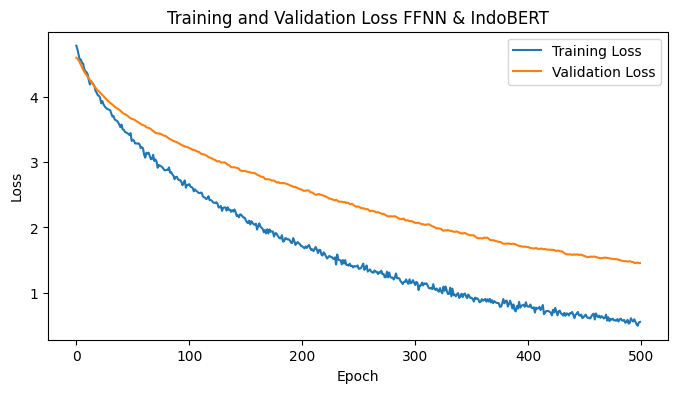

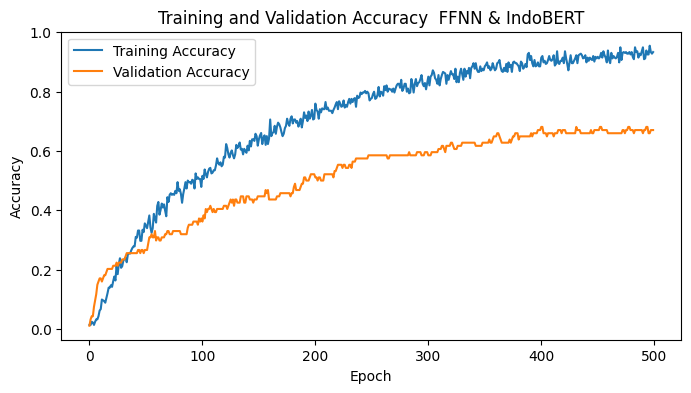

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(losses)), losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss FFNN & IndoBERT")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy")
plt.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy  FFNN & IndoBERT")
plt.legend()
plt.show()

Training Data:
Accuracy: 0.9893
F1 Score: 0.9851
Precision: 0.9823
Recall: 0.9893


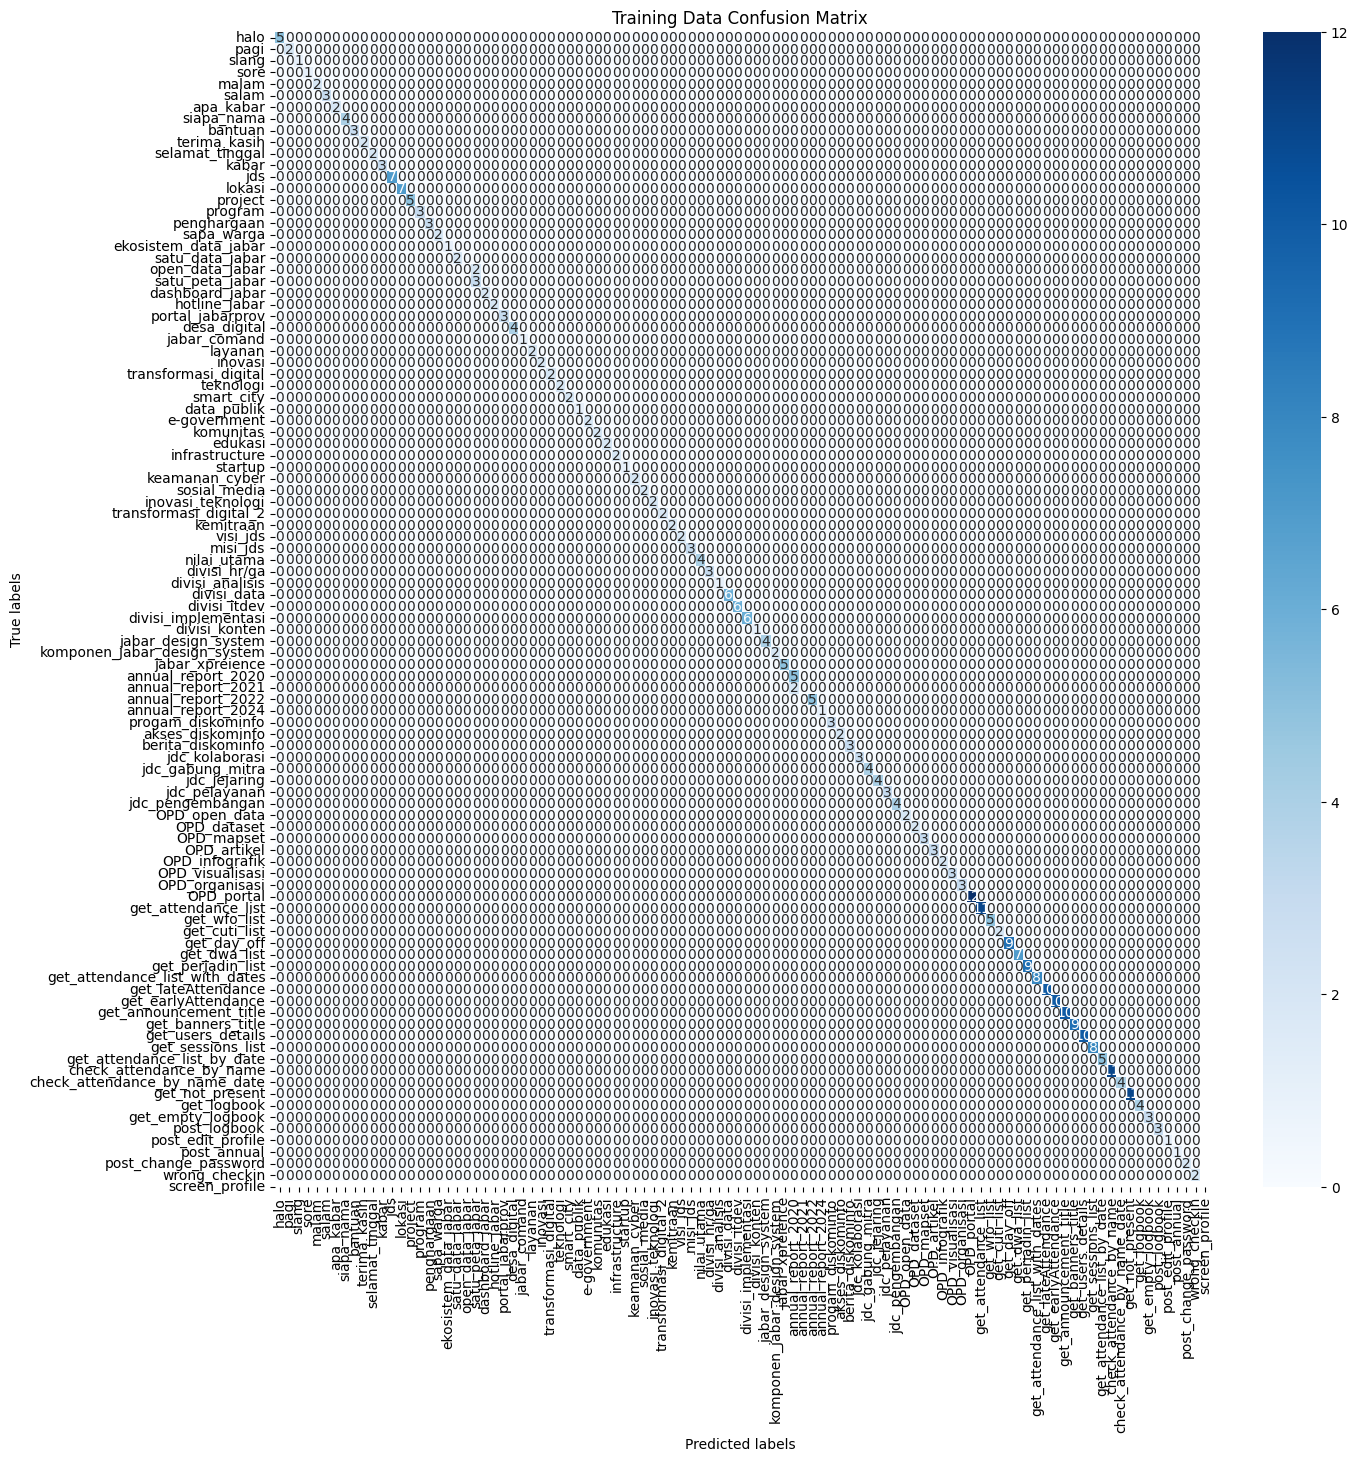

In [24]:
print("Training Data:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")

plt.figure(figsize=(15, 15))
sns.heatmap(
    train_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=tags,
    yticklabels=tags,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Training Data Confusion Matrix")
plt.show()

Validation Data:
Accuracy: 0.6702
F1 Score: 0.6572
Precision: 0.6787
Recall: 0.6702


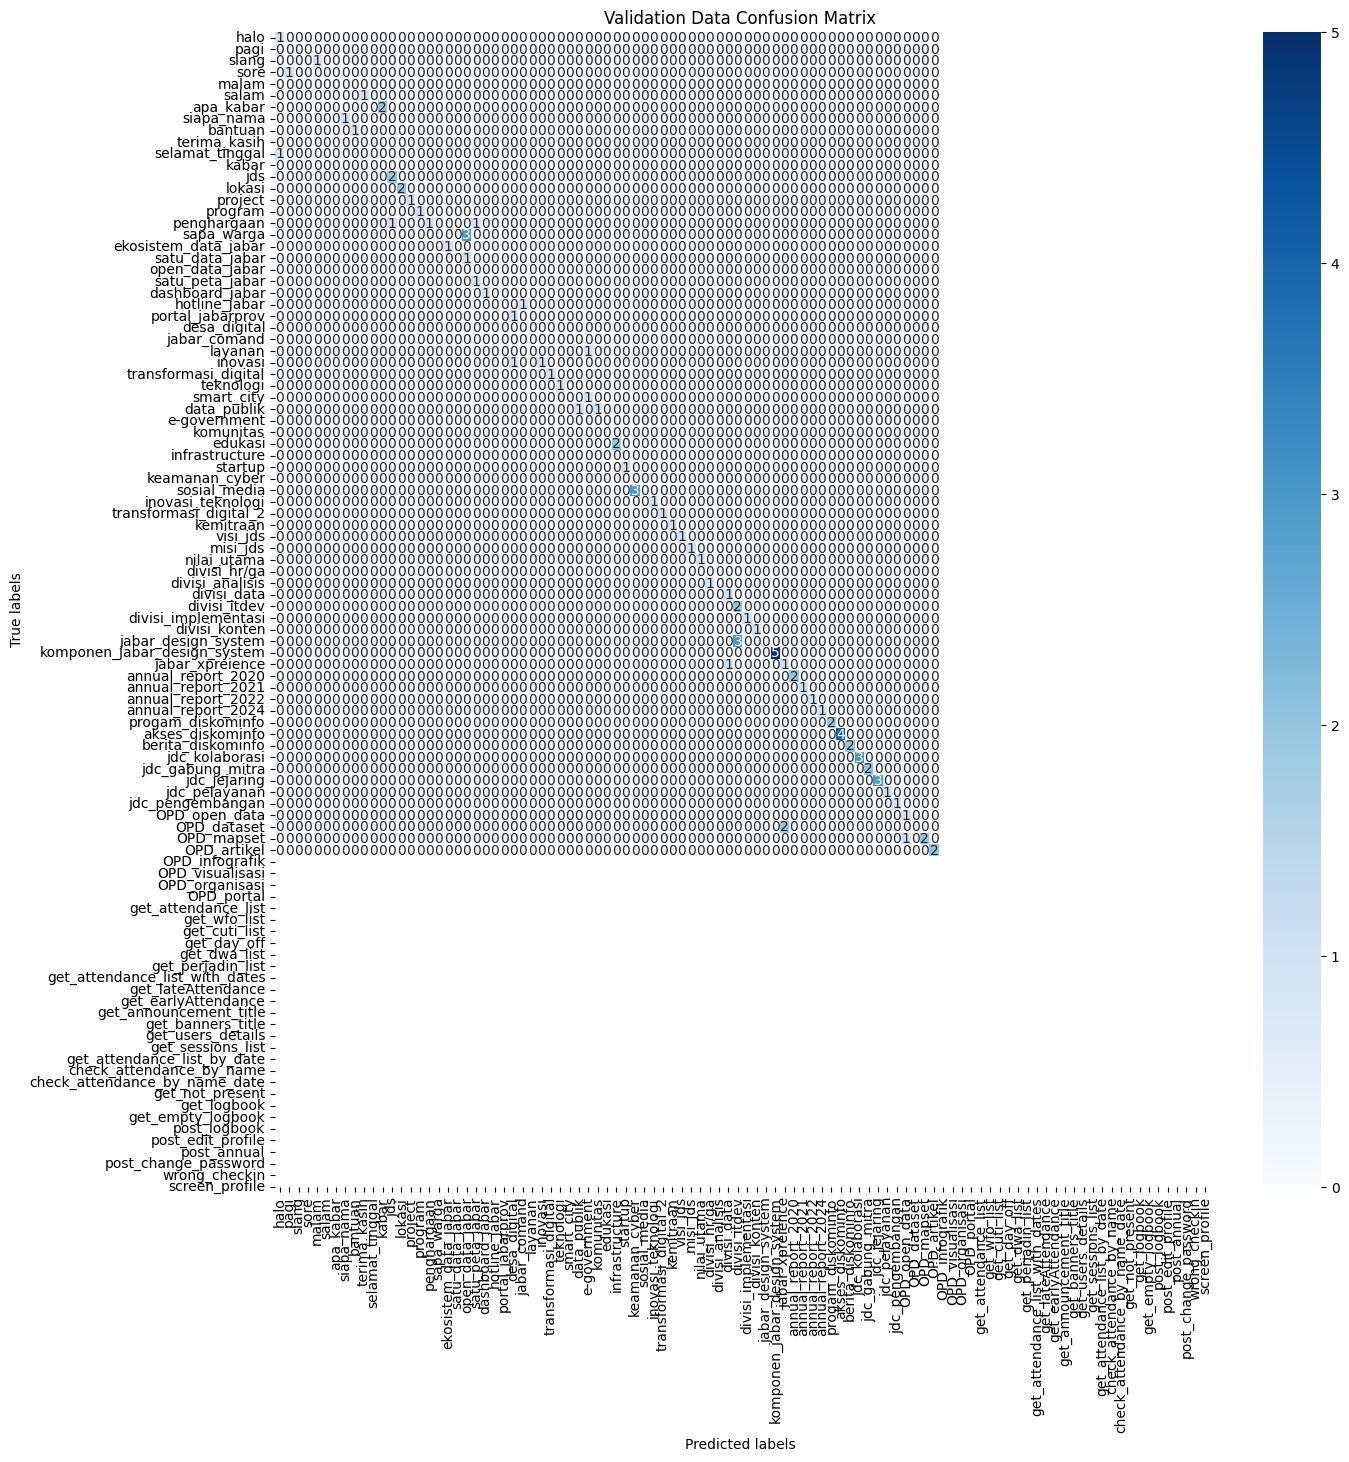

In [25]:
print("Validation Data:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall: {val_recall:.4f}")

plt.figure(figsize=(15, 15))
sns.heatmap(
    val_conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=tags,
    yticklabels=tags,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Validation Data Confusion Matrix")
plt.show()

In [26]:
def load_model(model_path):
    data = torch.load(model_path)
    model = NeuralNet(data["input_size"], data["hidden_size"], data["output_size"])
    model.load_state_dict(data["model_state"])
    model.eval()
    return model, data["tags"]


# Get BERT features from the input sentence
def get_bert_features(sentence, tokenizer, bert_model):
    tokenized_sentence = tokenizer(
        sentence, return_tensors="pt", padding=True, truncation=True, max_length=512
    )
    with torch.no_grad():
        outputs = bert_model(**tokenized_sentence.to(device))
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding


# Get response based on predicted tag
def get_response(tag, intents):
    for intent in intents["intents"]:
        if intent["tag"] == tag:
            return random.choice(intent["responses"])
    return "Tidak ada respon yang tersedia"


# Predict without dictionary
def predict_without_kamus(input_sentence, model, tags, tokenizer, bert_model):
    print(f"\nMemproses input tanpa kamus: {input_sentence}")
    features = get_bert_features(input_sentence, tokenizer, bert_model)
    features = np.array(features, dtype=np.float32)
    bag = torch.from_numpy(features).unsqueeze(0)

    with torch.no_grad():
        output = model(bag)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        predicted_tag = tags[predicted_class.item()]
        predicted_prob = probabilities[0][predicted_class.item()].item()

    print(f"Predicted tag tanpa kamus: {predicted_tag}")
    print(f"Probability tanpa kamus: {predicted_prob:.4f}")

    return predicted_tag, predicted_prob


# Predict and respond function
def predict_and_respond(user_input, model_path, intents_file):
    model, tags = load_model(model_path)
    intents = load_data(intents_file)

    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    bert_model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)

    tag_no_kamus, prob_no_kamus = predict_without_kamus(
        user_input, model, tags, tokenizer, bert_model
    )
    response_no_kamus = get_response(tag_no_kamus, intents)
    print(f"Response tanpa kamus: {response_no_kamus}\n")

    print(
        f"\n1. Prediksi tag tanpa kamus: {tag_no_kamus}, Probability: {prob_no_kamus:.4f}"
    )

    if prob_no_kamus > 0.75:
        print(f"\nRespons final: {response_no_kamus}")
    else:
        print(f"\nRespons final: Maaf, saya tidak mengerti")



In [27]:
# Main function
def main():
    model_path = "model_without_kamus.pth"
    intents_file = "intents.json"

    user_input = input("Anda: ")
    predict_and_respond(user_input, model_path, intents_file)


if __name__ == "__main__":
    main()

Data intents dimuat dari: intents.json
Jumlah intents: 100
Jumlah total patterns: 468
Jumlah total responses: 104

Memproses input tanpa kamus: How Carana Tingali List Logbook?
Predicted tag tanpa kamus: post_logbook
Probability tanpa kamus: 0.2859
Response tanpa kamus: 1. Menu Post Logbook  
2. Isikan semua yang ditandai (*) yang berarti wajib 
3. Cek kembali isian logbok apakah sudah sesuai 
4. Klik tombol submit untuk mengirim logbook 
5. Tunggu proses lalu otomatis ke halaman logbook.

Untuk menuju ke halaman logbook, silakan klik tautan berikut .


1. Prediksi tag tanpa kamus: post_logbook, Probability: 0.2859

Respons final: Maaf, saya tidak mengerti
